In [3]:
%load_ext autoreload
%autoreload 2

In [35]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import sys
sys.path.append('../src/dataset')
from mapillary_dataset import Mapillary_SemSeg_Dataset, N_LABELS
import albumentations as A
sys.path.append('../src')
from models import UNet
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [2]:
! ls ../data

LICENSE		  config_v2.0.json			    testing
README		  demo.py				    training
config_v1.2.json  mapillary-vistas-dataset_public_v2.0.zip  validation


In [46]:
data_dir = '../data/'

In [27]:
train_images_dir = os.path.join(data_dir, 'training/images')
train_labels_dir = os.path.join(data_dir, 'training/v2.0/labels')

In [63]:
train_image_files = os.listdir(train_images_dir)
train_label_files = os.listdir(train_labels_dir)

In [64]:
train_image_files[0], train_label_files[0]

('ooVVF3XDSAPcuqGc0UUq9A.jpg', 'ImkJ6D7d-uGne7mkqOQnSg.png')

In [35]:
'ooVVF3XDSAPcuqGc0UUq9A.png' in train_label_files

True

In [48]:
def apply_color_map(image_array, labels):
    color_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)

    for label_id, label in enumerate(labels):
        # set all pixels with the current label to the color of the current label
        color_array[image_array == label_id] = label["color"]

    return color_array
    
def plot_img_label(image_id='M2kh294N9c72sICO990Uew'):
    # read in config file
    with open(os.path.join(data_dir, 'config_v2.0.json')) as config_file:
        config = json.load(config_file)
    # in this example we are only interested in the labels
    labels = config['labels']
    print(len(labels))
    # print labels
    # print("There are {} labels in the config file".format(len(labels)))
    # for label_id, label in enumerate(labels):
    #     print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))

    # set up paths for every image
    image_path = os.path.join(data_dir, "training/images/{}.jpg".format(image_id))
    label_path = os.path.join(data_dir, "training/v2.0/labels/{}.png".format(image_id))
    # instance_path = "training/{}/instances/{}.png".format(version, image_id)
    # panoptic_path = "training/{}/panoptic/{}.png".format(version, image_id)

    # load images
    base_image = Image.open(image_path)
    label_image = Image.open(label_path)
    # instance_image = Image.open(instance_path)
    # panoptic_image = Image.open(panoptic_path)

    # convert labeled data to numpy arrays for better handling
    label_array = np.array(label_image)
    # instance_array = np.array(instance_image, dtype=np.uint16)

    # now we split the instance_array into labels and instance ids
    # instance_label_array = np.array(instance_array / 256, dtype=np.uint8)
    # instance_ids_array = np.array(instance_array % 256, dtype=np.uint8)

    # for visualization, we apply the colors stored in the config
    # print(label_array)

    plt.imshow(base_image)
    plt.show()
    colored_label_array = apply_color_map(label_array, labels)
    plt.imshow(colored_label_array)
    plt.show()


# image_fn = random.choice(train_image_files)
# plot_img_label(os.path.splitext(image_fn)[0])

## Visualize Augmentations

In [24]:
train_dataset = Mapillary_SemSeg_Dataset('training', '../data', (512, 512), augment=False, verbose=False)
test_dataset = Mapillary_SemSeg_Dataset('testing', '../data', (512, 512), augment=False, verbose=False)

In [81]:
train_dataset = iter(train_dataset)

In [84]:
image, mask = next(train_dataset)
image = image.transpose(1, 2, 0).astype(np.uint8)
mask = mask.transpose(1, 2, 0).astype(np.uint8)

augment_mode: 1


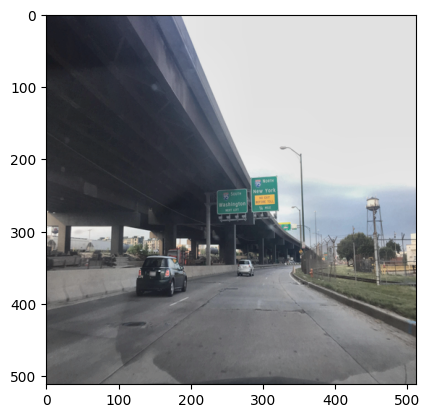

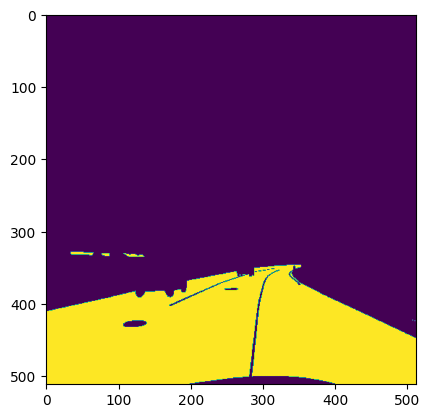

In [85]:
for a in (image, mask[:, :, 21]):
    plt.imshow(a)
    plt.show()


In [19]:
import sys
sys.path.append('..')
from src import train

notebooks  visualize.ipynb


## Inference

In [28]:
loader_args = dict(batch_size=4, num_workers=os.cpu_count()//2, pin_memory=True)
train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)

In [29]:
train_loader = iter(train_loader)

In [32]:
model = UNet(n_channels=3, n_classes=N_LABELS, bilinear=False)
model = model.to(memory_format=torch.channels_last)
epoch = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load(f'../checkpoints/4d7b88fd-ae01-4d2e-8aba-47011cddaf7c/checkpoint_epoch{epoch}.pth', weights_only=True, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

In [59]:
images, masks_true = next(train_loader)

In [60]:
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
masks_pred = model(images)
masks_pred = masks_pred.argmax(dim=1)


In [61]:
images[0].shape, masks_pred[0].shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [62]:
image = images[0].cpu().numpy().transpose(1, 2, 0)
image = (image*255).astype(np.uint8)
masks = masks_pred[0].cpu().numpy().astype(np.int32)


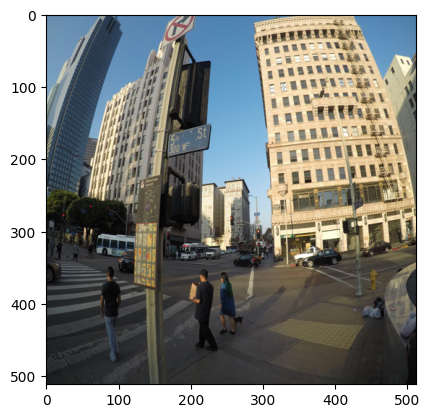

In [63]:
plt.imshow(image)
plt.show()

In [47]:
with open(os.path.join(data_dir, 'config_v2.0.json')) as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

In [64]:
colored_label_array = apply_color_map(masks, labels)

In [65]:
masks.shape

(512, 512)

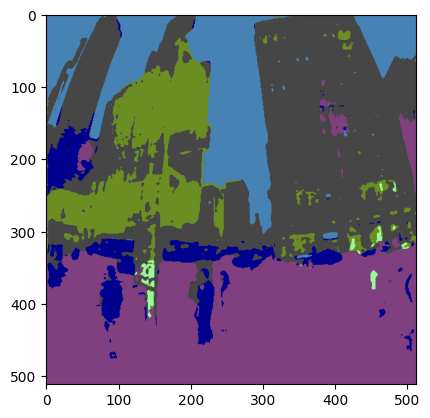

In [66]:
plt.imshow(colored_label_array)
plt.show()

In [68]:
masks_true = masks_true.argmax(dim=1)

In [69]:
masks_true.shape

torch.Size([4, 512, 512])

In [70]:
mask_true = masks_true[0]

In [71]:
colored_label_array_true = apply_color_map(mask_true, labels)

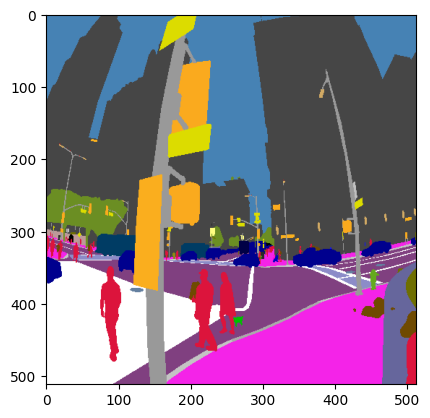

In [72]:
plt.imshow(colored_label_array_true)
plt.show()